In [1]:
# %%
# Evaluate CNN vs XGBoost - Comparative Analysis

import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # type: ignore
import xgboost as xgb 
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, mean_squared_error,
    mean_absolute_error, roc_curve
)

In [2]:
# %%
# Configuration
KERAS_MODEL_PATH = "fracture_detection_model.h5"
XGB_META = "xgb_model_meta.joblib"
FEATURES_NPZ = Path("features") / "deep_features.npz"
CLASS_INDICES_PATH = "class_indices.json"
VAL_DIR = "data/val"

IMG_SIZE_CNN = (128, 128)
BATCH_SIZE = 32
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)


In [3]:
# %%
# Load models & class mapping
with open(CLASS_INDICES_PATH, "r") as f:
    class_indices = json.load(f)
idx_to_class = {v: k for k, v in class_indices.items()}

cnn_model = tf.keras.models.load_model(KERAS_MODEL_PATH)
meta = joblib.load(XGB_META)
booster = xgb.Booster()
booster.load_model(meta["booster_path"])

data = np.load(FEATURES_NPZ, allow_pickle=True)
X_val_feats = data["X_val"]
y_val_xgb = data["y_val"]

val_gen = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE_CNN,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    classes=[idx_to_class[i] for i in sorted(idx_to_class.keys())],
    shuffle=False
)


Found 600 images belonging to 2 classes.


In [4]:
# %%
# CNN predictions
val_gen.reset()
y_true_cnn = val_gen.classes
cnn_probs = cnn_model.predict(val_gen, verbose=1).ravel()
cnn_preds = (cnn_probs > 0.5).astype(int)

# XGBoost predictions
dval = xgb.DMatrix(X_val_feats)
xgb_probs = booster.predict(dval)
xgb_preds = (xgb_probs > 0.5).astype(int)

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step


In [5]:
# %%
# Metrics computation
from math import sqrt

def compute_metrics(y_true, y_pred, y_prob):
    m = {}
    m["Accuracy"] = accuracy_score(y_true, y_pred)
    m["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    m["Recall"] = recall_score(y_true, y_pred, zero_division=0)
    m["F1-Score"] = f1_score(y_true, y_pred, zero_division=0)
    m["AUC"] = roc_auc_score(y_true, y_prob)
    m["MSE"] = mean_squared_error(y_true, y_prob)
    m["MAE"] = mean_absolute_error(y_true, y_prob)
    m["RMSE"] = sqrt(m["MSE"])
    return m

cnn_metrics = compute_metrics(y_true_cnn, cnn_preds, cnn_probs)
xgb_metrics = compute_metrics(y_val_xgb, xgb_preds, xgb_probs)

cnn_metrics["Loss"] = cnn_model.evaluate(val_gen, verbose=0)[0]
xgb_metrics["Loss"] = mean_squared_error(y_val_xgb, xgb_probs)

metrics_df = pd.DataFrame([cnn_metrics, xgb_metrics], index=["CNN", "XGBoost"])
metrics_df = metrics_df.round(4)
metrics_df.to_csv(RESULTS_DIR / "model_comparison.csv")
metrics_df


,Accuracy,Precision,Recall,F1-Score,AUC,MSE,MAE,RMSE,Loss
CNN,0.6083,0.6268,0.8583,0.7245,0.7432,0.2455,0.3649,0.4955,0.7072
XGBoost,0.7500,0.7966,0.7833,0.7899,0.8253,0.1685,0.3188,0.4105,0.1685


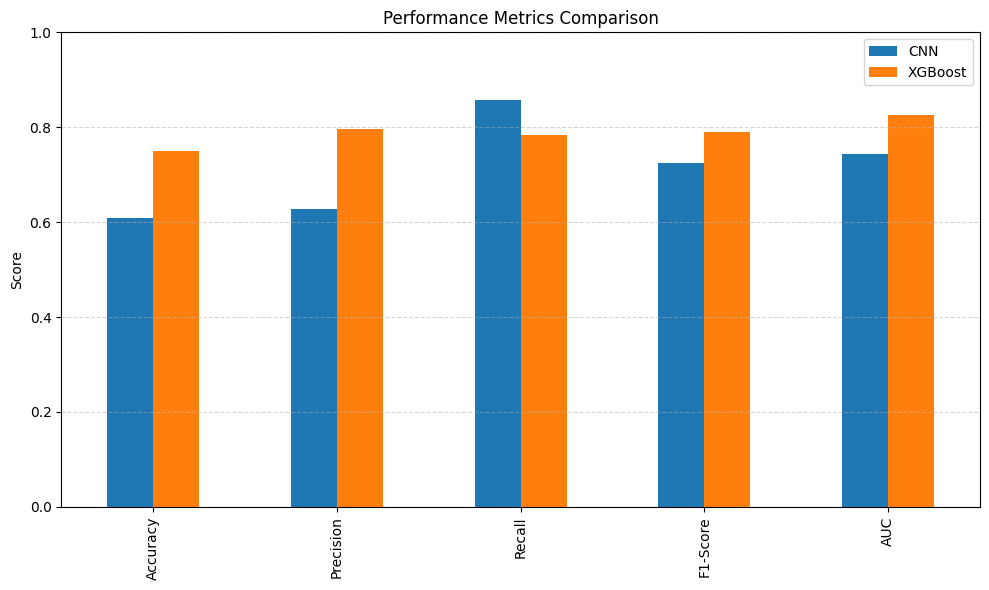

In [6]:
# %%
# Plot 1: Bar chart comparison
core_metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
metrics_df[core_metrics].T.plot(kind="bar", figsize=(10, 6))
plt.title("Performance Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "metrics_comparison.png")
plt.show()


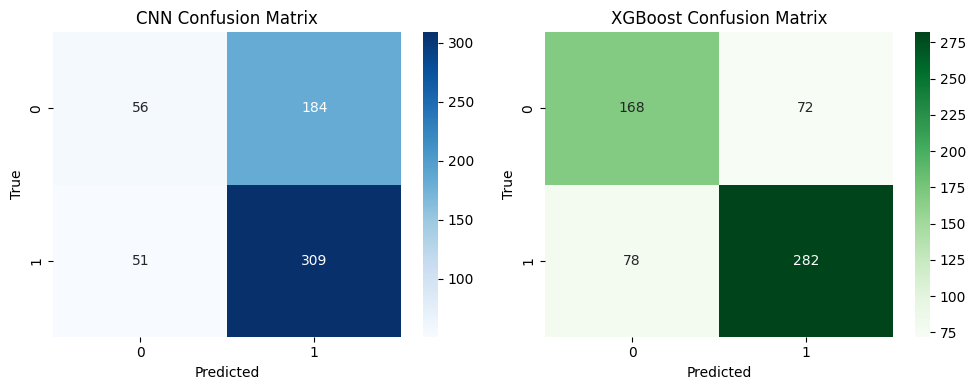

In [7]:
# %%
# Plot 2: Confusion matrices
cm_cnn = confusion_matrix(y_true_cnn, cnn_preds)
cm_xgb = confusion_matrix(y_val_xgb, xgb_preds)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "confusion_matrices.png")
plt.show()

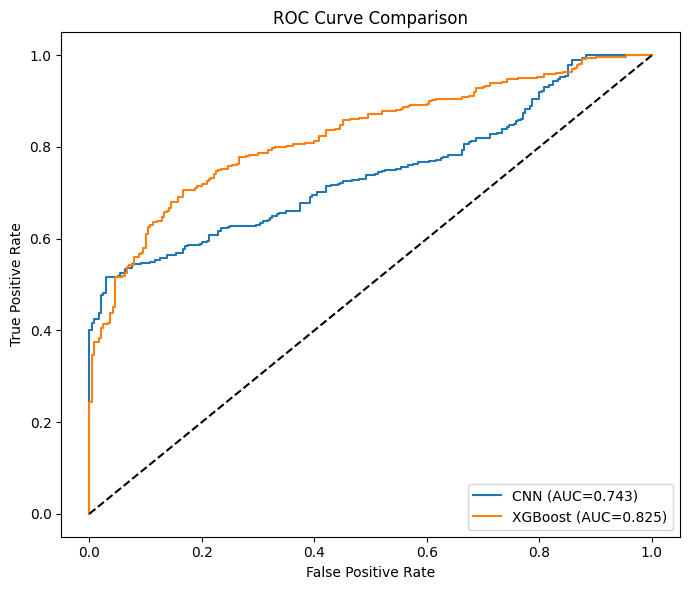

In [8]:
# %%
# Plot 3: ROC curve comparison
fpr_c, tpr_c, _ = roc_curve(y_true_cnn, cnn_probs)
fpr_x, tpr_x, _ = roc_curve(y_val_xgb, xgb_probs)

plt.figure(figsize=(7, 6))
plt.plot(fpr_c, tpr_c, label=f"CNN (AUC={metrics_df.loc['CNN', 'AUC']:.3f})")
plt.plot(fpr_x, tpr_x, label=f"XGBoost (AUC={metrics_df.loc['XGBoost', 'AUC']:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "roc_comparison.png")
plt.show()

In [9]:
# %%
# Summary printout
print("=== Comparative Summary ===")
print(metrics_df)
print("\nResults saved in the 'results/' folder.")

=== Comparative Summary ===
         Accuracy  Precision  Recall  F1-Score     AUC     MSE     MAE  \
CNN        0.6083     0.6268  0.8583    0.7245  0.7432  0.2455  0.3649   
XGBoost    0.7500     0.7966  0.7833    0.7899  0.8253  0.1685  0.3188   

           RMSE    Loss  
CNN      0.4955  0.7072  
XGBoost  0.4105  0.1685  

Results saved in the 'results/' folder.
